# Feature Selection

# OLD CODE

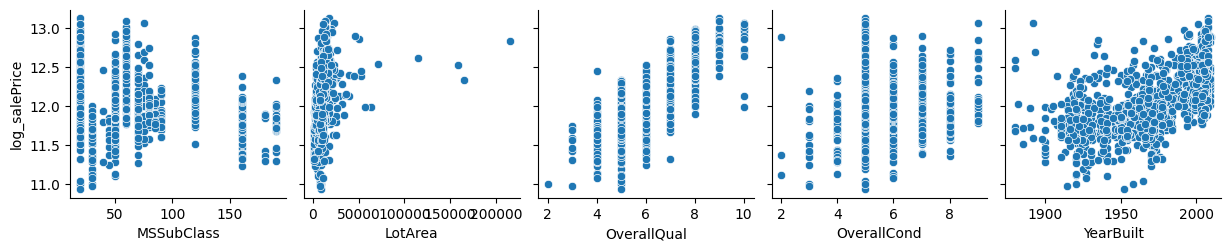

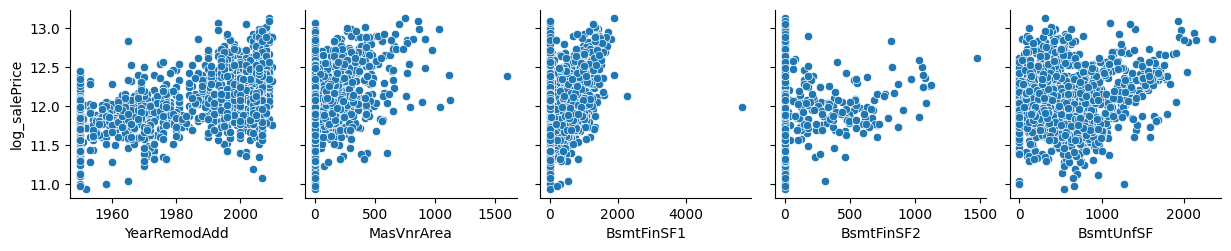

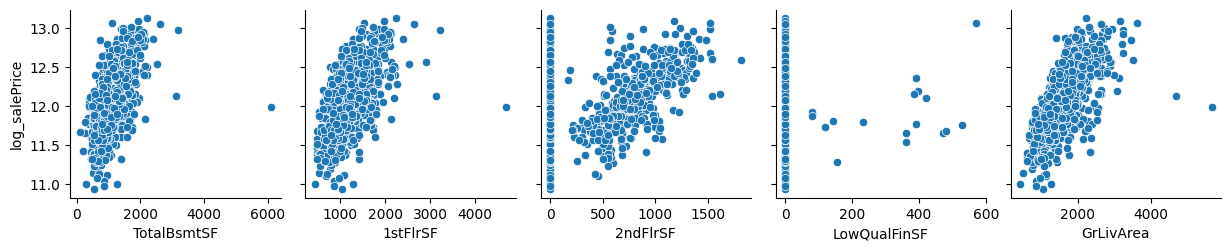

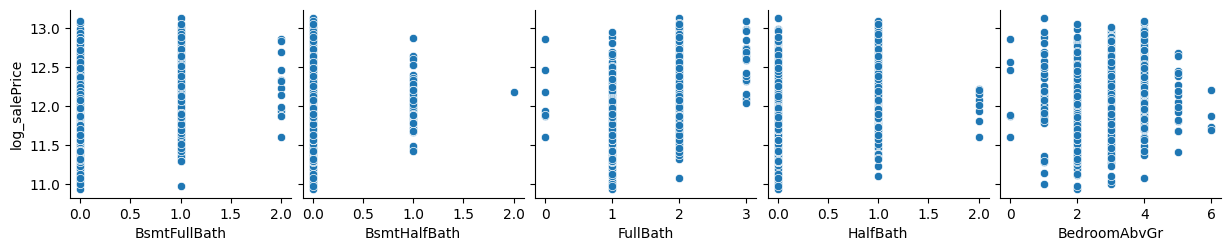

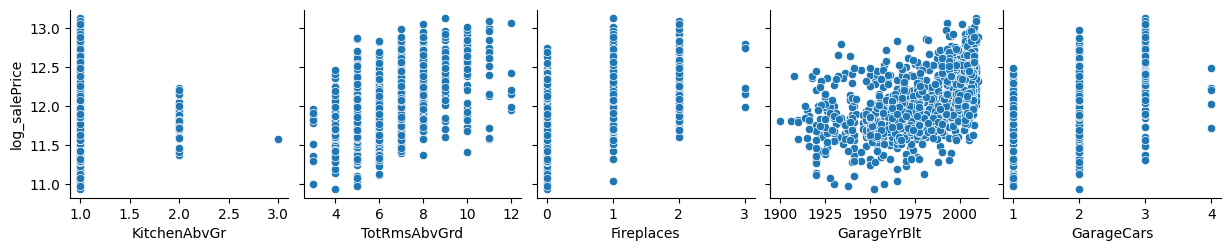

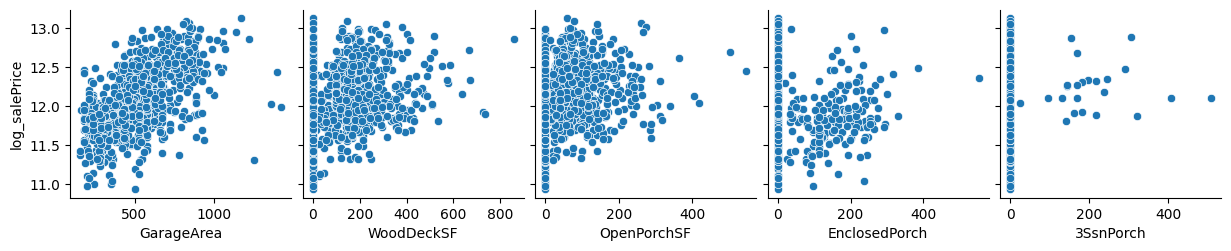

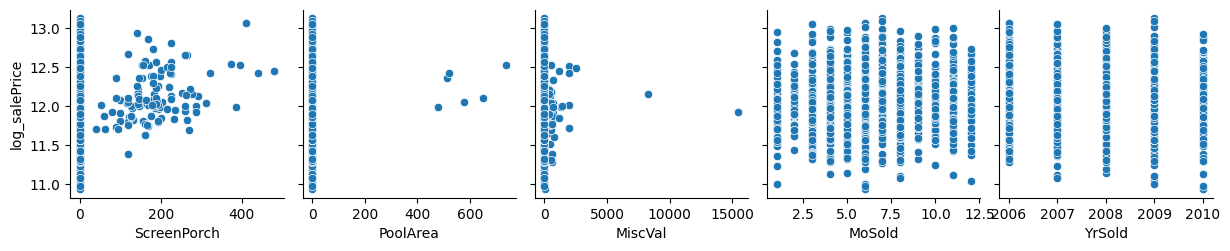

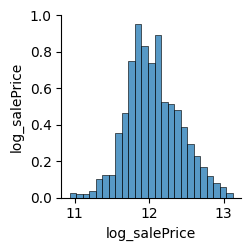

In [ ]:
# Plotting the correlation between each numeric feature and the target
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(
        data=df_num, 
        x_vars=df_num.columns[i:i+5], 
        y_vars=['log_salePrice'],
        height= 2.5
    )
    

From the above we can see that there does appear to be correlation between some features and the target. Let now quantify this correlation and look at the top 15 highly correlated features. We will choose 15 to start with as this will likely then reduce with some features being highly correlated to one another.

In [ ]:
# Finding the 15 most highly correlated features with the target
X_num = df_num.drop(columns='log_salePrice')
y_num = df_num['log_salePrice']

df_num_corr = X_num.apply(lambda x: x.corr(y_num))
num_corr_list = abs(df_num_corr).sort_values(ascending=False)
print(f'The top 15 correlated numerical features to the target are:\n{num_corr_list[0:15]}')

The top 15 correlated numerical features to the target are:
OverallQual     0.799448
GrLivArea       0.688004
GarageCars      0.653931
GarageArea      0.606399
FullBath        0.596204
1stFlrSF        0.580086
YearBuilt       0.575077
YearRemodAdd    0.568219
TotalBsmtSF     0.568072
GarageYrBlt     0.536041
TotRmsAbvGrd    0.529398
Fireplaces      0.462599
MasVnrArea      0.400180
OpenPorchSF     0.351119
BsmtFinSF1      0.318431
dtype: float64


As a sanity check we will use the sklearn 'SelectKBest' to also find the 15 monst correlated numerical features with the target and then check that it matches the above.

In [ ]:
# Finding the 15 most highly correlated features with the target
from sklearn.feature_selection import SelectKBest, f_regression

num_fs = SelectKBest(f_regression, k=15)
Xt_num = num_fs.fit_transform(X_num, y_num)
print(X_num.shape)
print(Xt_num.shape)
num_fs.get_feature_names_out()


(1328, 35)
(1328, 15)


array(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'OpenPorchSF'], dtype=object)

In [ ]:
# Confirming the 15 most highly correlated numerical features to the target from each method matches.
set(num_corr_list.index[0:15]) == set(num_fs.get_feature_names_out())

True

Lets now take these most highly correlated numerical features to the target and check whether they are correlated to one another.

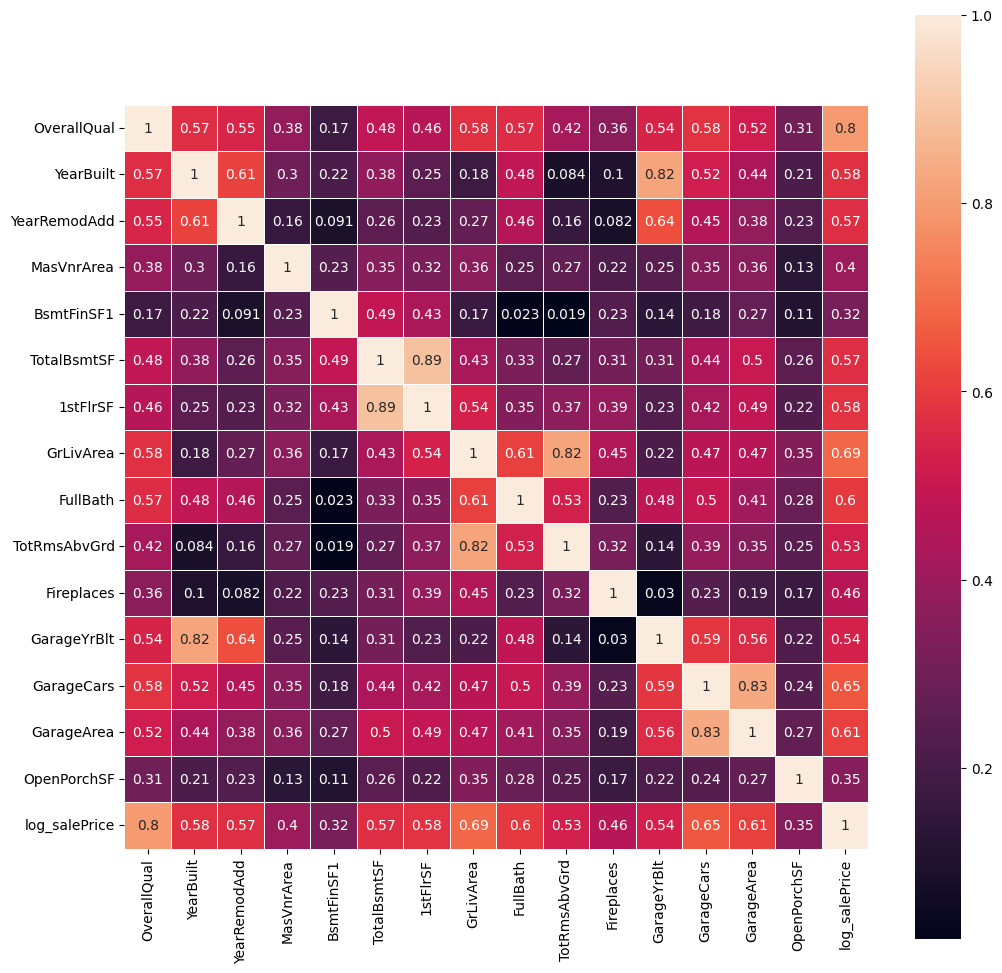

In [ ]:
# Creating a dataframe just featuring the 15 most highly correlated numerical features to the target
df_num_fs = pd.concat([df_num[num_fs.get_feature_names_out()], df_num['log_salePrice']], axis=1)

# Checking the correlations between each feature (including the target)
num_corr = df_num_fs.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(num_corr, annot=True, square=True, linewidths=.5, ax=ax);

From the correlation heatmap above we can see that there are some numerical features that are highly correlated. Since highly correlated features will not add much extra information to the model, we will drop the ones that are less correlated to the target. I am going to set the correlation threshold to 0.8 for features to be dropped.

Using this criteria identifies the following features to be dropped:
* GarageYrBlt
* TotalBsmtSF
* TotRmsAbvGrd
* GarageArea

In [ ]:
# Dropping the highly correlated features
df_num_fs.drop(columns=['GarageYrBlt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea'], inplace=True)
df_num_fs.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,1stFlrSF,GrLivArea,FullBath,Fireplaces,GarageCars,OpenPorchSF,log_salePrice
0,7,2003,2003,196.0,706,856,1710,2,0,2,61,12.247694
1,6,1976,1976,0.0,978,1262,1262,2,1,2,0,12.109011
2,7,2001,2002,162.0,486,920,1786,2,1,2,42,12.317167
3,7,1915,1970,0.0,216,961,1717,1,1,3,35,11.849398
4,8,2000,2000,350.0,655,1145,2198,2,1,3,84,12.429216


Now we will once again check the remaining numerical features correlation to the target and decide whether to remove any low correlation features.

In [ ]:
# Checking the correlations of each remaining numerical feature to the target again
X_num = df_num_fs.drop(columns='log_salePrice')
y_num = df_num_fs['log_salePrice']
df_num_corr = X_num.apply(lambda x: x.corr(y_num))
num_corr_list = abs(df_num_corr).sort_values(ascending=False)
num_corr_list

OverallQual     0.799448
GrLivArea       0.688004
GarageCars      0.653931
FullBath        0.596204
1stFlrSF        0.580086
YearBuilt       0.575077
YearRemodAdd    0.568219
Fireplaces      0.462599
MasVnrArea      0.400180
OpenPorchSF     0.351119
BsmtFinSF1      0.318431
dtype: float64

If we set a correlation to target threshold of 0.3 to begin with then we will keep all the remaining numerical features. Lets just put them into a list for future use.

In [ ]:
num_features = num_corr_list.index
num_features

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', '1stFlrSF',
       'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'OpenPorchSF',
       'BsmtFinSF1'],
      dtype='object')

# Categorical Feature Investigation

Next we will investigate the categorical features in the dataset and identify those that will provide the most information to the model.

In [ ]:
# Identifying the categorical features in the dataset
print(set(df3.dtypes.to_list()))

# Obtaining a dataframe of just categorical features
df_cat = df3.select_dtypes('O')
df_cat.head()

{dtype('float64'), dtype('int64'), dtype('O')}


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [ ]:
# Finding the 15 most highly correlated features with the target
df_cat_corr = df_cat_fs.apply(lambda x: x.corr(y_num))
cat_corr_list = abs(df_cat_corr).sort_values(ascending=False)
print(f'The top 15 correlated categorical features to the target are:\n{cat_corr_list[0:15]}')

The top 15 correlated categorical features to the target are:
ord_ExterQual           0.670404
ord_BsmtQual            0.659613
ord_KitchenQual         0.656083
ord_GarageFinish        0.547243
Foundation_PConc        0.526627
GarageType_Detchd       0.469471
ord_HeatingQC           0.463596
Foundation_CBlock       0.379106
MSZoning_RM             0.364058
GarageType_Attchd       0.361485
MasVnrType_None         0.360209
Exterior2nd_VinylSd     0.357896
Exterior1st_VinylSd     0.356606
Neighborhood_NridgHt    0.351640
MasVnrType_Stone        0.302972
dtype: float64


If we again set a threshold correlation of 0.3 we will keep all of the above categorical features to develop a model with. Lets again store these feature names for future use and also plot the distrbutions of the top 15 categorical features with respect to log_salePrice.

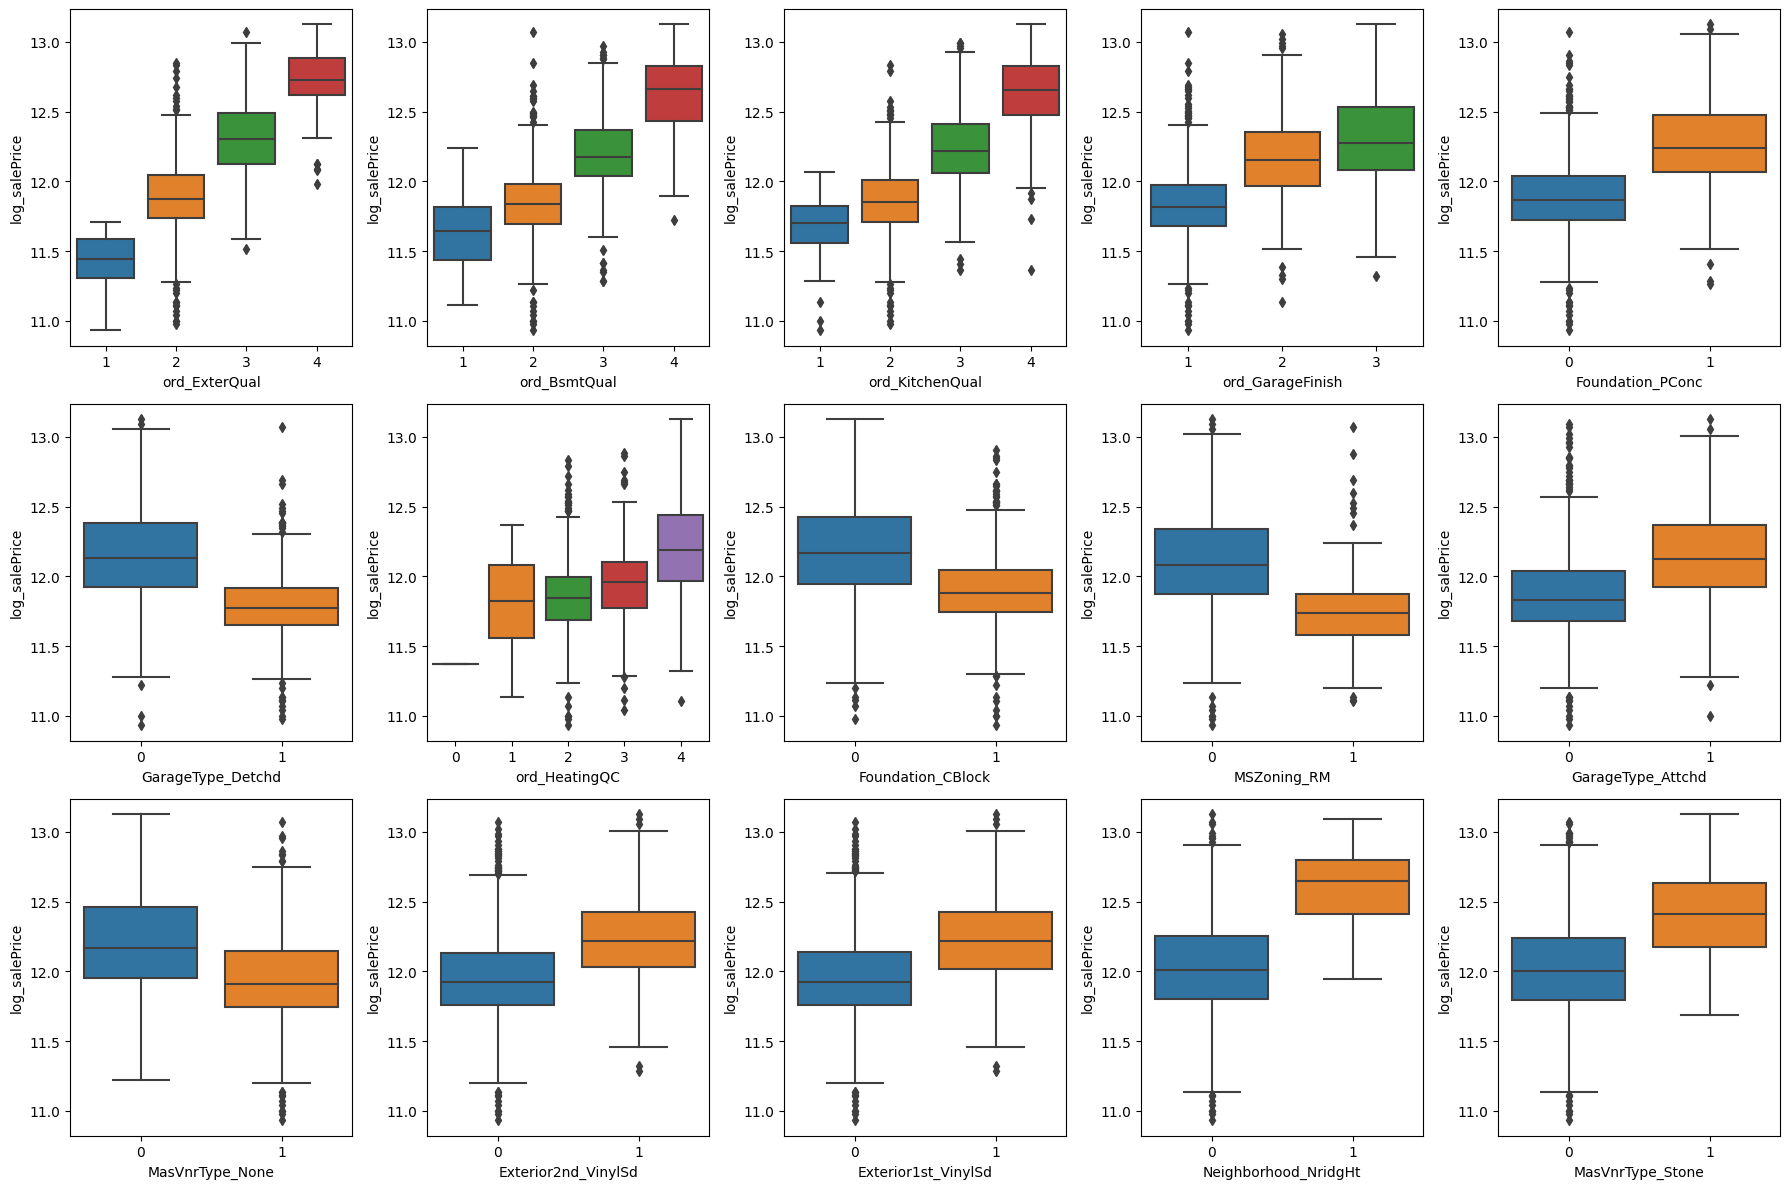

In [ ]:
# Getting the feature names of the top 15 features
cat_features = cat_corr_list.index[:15]

# Plotting the correlation between each numeric feature and the target
df_cat_fs = pd.concat([df_cat_fs[cat_features], y_num], axis=1)

fig, axes = plt.subplots(3,5, figsize=(18,12))
for i, ax in enumerate(fig.axes):
    sns.boxplot(
        data = df_cat_fs,
        x = cat_features[i],
        y = 'log_salePrice',
        ax=ax
    )

plt.tight_layout()

# Feature Selected Data

We will now combine the numerical and categorical feature selected data before saving it. We will also combine and save all the chosen feature names in case we need to use them in any pipelines later.

In [ ]:
# Combining the selected numerical and categorical features into a dataframe 
df_fs = df_num_fs.merge(right=df_cat_fs, left_index=True, right_index=True)
df_fs.drop(columns='log_salePrice_x', inplace=True)

print(df_num_fs.shape)
print(df_cat_fs.shape)
print(df_fs.shape)

df_fs.head()

(1328, 12)
(1328, 16)
(1328, 27)


,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,1stFlrSF,GrLivArea,FullBath,Fireplaces,GarageCars,...,ord_HeatingQC,Foundation_CBlock,MSZoning_RM,GarageType_Attchd,MasVnrType_None,Exterior2nd_VinylSd,Exterior1st_VinylSd,Neighborhood_NridgHt,MasVnrType_Stone,log_salePrice_y
0,7,2003,2003,196.0,706,856,1710,2,0,2,...,4,0,0,1,0,1,1,0,0,12.247694
1,6,1976,1976,0.0,978,1262,1262,2,1,2,...,4,1,0,1,1,0,0,0,0,12.109011
2,7,2001,2002,162.0,486,920,1786,2,1,2,...,4,0,0,1,0,1,1,0,0,12.317167
3,7,1915,1970,0.0,216,961,1717,1,1,3,...,3,0,0,0,1,0,0,0,0,11.849398
4,8,2000,2000,350.0,655,1145,2198,2,1,3,...,4,0,0,1,0,1,1,0,0,12.429216


In [ ]:
df_fs.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars',
       'OpenPorchSF', 'ord_ExterQual', 'ord_BsmtQual', 'ord_KitchenQual',
       'ord_GarageFinish', 'Foundation_PConc', 'GarageType_Detchd',
       'ord_HeatingQC', 'Foundation_CBlock', 'MSZoning_RM',
       'GarageType_Attchd', 'MasVnrType_None', 'Exterior2nd_VinylSd',
       'Exterior1st_VinylSd', 'Neighborhood_NridgHt', 'MasVnrType_Stone',
       'log_salePrice_y'],
      dtype='object')

In [ ]:
# Saving the feature selected dataframe
df_fs.to_csv(r'../data/formatted_data/train_fs_1.0')